## Hidden layer를 사용하는 Keras 기반의 MF(Matrix Factorization, 행렬 요인화) 구현
- 평가가 적음으로 평점이 적게 학습됨으로 평균을 사전에 파악한후 예측 결과에 추가하여 평점을 높임.

In [1]:
import os
import time

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t', encoding='utf-8')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings) # DataFrame형태의 데이터를 무작위로 섞음
cutoff = int(TRAIN_SIZE * len(ratings))
print('cutoff:', cutoff)
ratings_train = ratings.iloc[:cutoff] # 0:75000
ratings_test = ratings.iloc[cutoff:]  # 75000:100000

cutoff: 75000


In [2]:
# u.item 파일을 DataFrame으로 읽기
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('./data/u.item', sep='|', names=i_cols, encoding='utf-8')
movies = movies.set_index('movie_id')
movies.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
movies.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='movie_id', length=1682)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장

In [5]:
print(ratings.user_id.max())
print(ratings.user_id.max()+1) # ratings.iloc[:944] 0 ~ 943
print(ratings.movie_id.max())
print(ratings.movie_id.max()+1) # ratings.iloc[:1683] 0 ~ 1682

943
944
1682
1683


In [6]:
# Variable 초기화 
K = 200                             # Latent factor 수, 잠재 요인수 
mu = ratings_train.rating.mean()    # 전체 평균, 연산의 규모를 줄이기 위하여  
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

# Defining RMSE measure, https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
# def RMSE(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # 전부 더해져서 평균을 Scalar 형태로 변환

In [7]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
# Embedding(입력차원, 출력차원, 정규화 알고리즘)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
print(P_embedding.shape)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
print(Q_embedding.shape)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

(None, 1, 200)
(None, 1, 200)


In [8]:
# layers.dot
x = np.arange(4).reshape(2, 2)
print(x)

[[0 1]
 [2 3]]


In [9]:
y = np.arange(4).reshape(2, 2)
print(y)

[[0 1]
 [2 3]]


In [10]:
# 0 * 0 + 1 * 1, 2 * 2 + 3 * 3
layers.dot([x, y], axes=1) # 0 지원 안함, 1: 행우선(행단위) 연산

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[ 1],
       [13]])>

In [11]:
# layers.dot([x, y], axes=2) # ERROR, 2: 행우선(행단위) 연산
x = np.arange(3).reshape(1, 1, 3)
print(x)
y = np.arange(3).reshape(1, 1, 3)
print(y)

[[[0 1 2]]]
[[[0 1 2]]]


In [12]:
layers.dot([x, y], axes=1) 

<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4]]])>

In [13]:
layers.dot([x, y], axes=2) # 열우선 연산

<tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[5]]])>

In [14]:
# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

In [15]:
# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

In [16]:
model = Model(inputs=[user, item], outputs=R)
model.compile(loss='mse', optimizer=Adam(lr=0.001),metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

C:\Users\user\anaconda3\envs\ai\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# Model fitting
# mcp = ModelCheckpoint(filepath='./personalization.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)
es = EarlyStopping(patience=5, restore_best_weights=True)

start = time.time()
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=30, batch_size=128,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values], ratings_test.rating.values - mu
  ), 
  callbacks=[es]
)
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# Epoch 00030, i5 2320: 554s, i5 8500: 250s, Colab GPU: s

Epoch 1/30
586/586 [==============================] - 26s 41ms/step - loss: 1.3201 - mse: 0.9974 - val_loss: 1.0622 - val_mse: 0.9491
Epoch 2/30
586/586 [==============================] - 24s 40ms/step - loss: 1.0340 - mse: 0.9357 - val_loss: 0.9943 - val_mse: 0.9195
Epoch 3/30
586/586 [==============================] - 24s 41ms/step - loss: 0.9939 - mse: 0.9123 - val_loss: 0.9912 - val_mse: 0.9114
Epoch 4/30
586/586 [==============================] - 33s 56ms/step - loss: 0.9683 - mse: 0.8966 - val_loss: 0.9504 - val_mse: 0.8903
Epoch 5/30
586/586 [==============================] - 40s 68ms/step - loss: 0.9675 - mse: 0.8922 - val_loss: 0.9520 - val_mse: 0.8873
Epoch 6/30
586/586 [==============================] - 30s 51ms/step - loss: 0.9661 - mse: 0.8897 - val_loss: 0.9585 - val_mse: 0.8918
Epoch 7/30
586/586 [==============================] - 27s 46ms/step - loss: 0.9567 - mse: 0.8872 - val_loss: 0.9809 - val_mse: 0.8992
Epoch 8/30
586/586 [==============================] - 35s 60ms

In [18]:
model.save('./personalization_mu_mlp.h5')

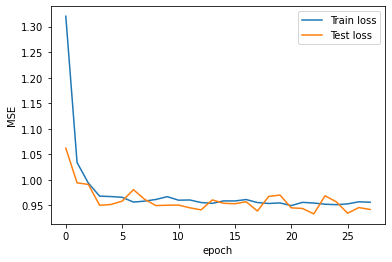

In [19]:
import matplotlib.pyplot as plt
plt.plot(result.history['loss'], label="Train loss")
plt.plot(result.history['val_loss'], label="Test loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [20]:
# 테스트 데이터 Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

1/1 [==============================] - 1s 679ms/step
Actuals: 
        user_id  movie_id  rating
38577      455        89       3
15921       49       386       4
85207      901       393       5
8270       267       384       3
99044      404       288       3
92324       26      1010       2

Predictions: 
 [[4.2610683]
 [2.050893 ]
 [3.9207935]
 [3.1148226]
 [3.2202659]
 [3.1535454]]


In [21]:
df6 = ratings_test[0:6]
df6

,user_id,movie_id,rating
38577,455,89,3
15921,49,386,4
85207,901,393,5
8270,267,384,3
99044,404,288,3
92324,26,1010,2


In [22]:
# print(type(predictions))
df6['predictions'] = predictions
df6

C:\Users\user\anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,movie_id,rating,predictions
38577,455,89,3,4.261068
15921,49,386,4,2.050893
85207,901,393,5,3.920794
8270,267,384,3,3.114823
99044,404,288,3,3.220266
92324,26,1010,2,3.153545


In [23]:
ratings_test[0:6]

,user_id,movie_id,rating
38577,455,89,3
15921,49,386,4
85207,901,393,5
8270,267,384,3
99044,404,288,3
92324,26,1010,2


In [24]:
df6.sort_values('predictions', ascending=False, inplace=True)
df6

C:\Users\user\anaconda3\envs\ai\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,user_id,movie_id,rating,predictions
38577,455,89,3,4.261068
85207,901,393,5,3.920794
99044,404,288,3,3.220266
92324,26,1010,2,3.153545
8270,267,384,3,3.114823
15921,49,386,4,2.050893


In [25]:
# Prediction
user_ids = ratings_test.user_id.values
print(type(user_ids))
print(user_ids.shape)
movie_ids = ratings_test.movie_id.values
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

<class 'numpy.ndarray'>
(25000,)
782/782 [==============================] - 8s 11ms/step
Actuals: 
        user_id  movie_id  rating
38577      455        89       3
15921       49       386       4
85207      901       393       5
8270       267       384       3
99044      404       288       3
92324       26      1010       2

Predictions: 
 [[4.2610683]
 [2.0508928]
 [3.9207935]
 ...
 [3.644756 ]
 [2.960249 ]
 [3.0623846]]


In [26]:
df = ratings_test.copy()
# print(type(predictions))
df['predictions'] = predictions
df.sort_values('predictions', ascending=False, inplace=True)
df.head(10)

,user_id,movie_id,rating,predictions
86327,907,483,4,5.533069
82908,330,64,5,5.451358
64151,907,100,5,5.317462
43212,472,12,5,5.308960
36238,507,316,5,5.299532
96351,907,427,5,5.293610
64083,821,318,5,5.243155
243,200,318,5,5.231485
14087,330,172,5,5.208917
88290,332,64,5,5.201848


In [27]:
df[df['user_id'] == 1].head(10)

,user_id,movie_id,rating,predictions
17672,1,100,5,4.188159
3246,1,132,4,4.082230
31742,1,205,3,4.077847
53552,1,127,5,4.053761
20952,1,22,4,4.037383
10207,1,183,5,4.034116
10922,1,242,5,3.982242
687,1,171,5,3.922925
59972,1,168,5,3.914577
47860,1,87,5,3.909958


### 개별 회원 추천

In [28]:
# def RMSE(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # 전부 더해져서 평균을 Scalar 형태로 변환

# 모델 로딩
model = load_model('./personalization_mu_mlp.h5')

# 영화 로딩
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('./data/u.item', sep='|', names=i_cols, encoding='utf-8')
movies = movies.set_index('movie_id')
display(movies.head())

# 평점 로딩
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t', encoding='utf-8')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거
display(ratings.head())

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [29]:
# 아직 보지 않은 영화 리스트 함수
def get_unseen(ratings, movies, user_id):
     # 특정 user_id가 평점을 매긴 모든 영화 리스트
    seen_movies = ratings[ratings['user_id']== user_id]['movie_id'].tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
#     total_movies = movies['movie_id'].tolist()
    total_movies = movies.index.tolist()
#     print(total_movies)
      
    # 한줄 for + if문으로 안 본 영화 리스트 생성
    unseen_movies = [ movie for movie in total_movies if movie not in seen_movies]
    
    # 일부 정보 출력
    total_movie_cnt = len(total_movies)
    seen_cnt = len(seen_movies)
    unseen_cnt = len(unseen_movies)
    
    print(f"전체 영화 수: {total_movie_cnt}, 평점 매긴 영화 수: {seen_cnt}, 추천 대상 영화 수: {unseen_cnt}")
    
    return unseen_movies

In [30]:
user_id = int(input('회원 번호를 입력하세요(1):'))
unseen_movies = get_unseen(ratings, movies, user_id)
# recomm_movie_by_surprise(model, userId, unseen_movies, top_n=10)

회원 번호를 입력하세요(1):1
전체 영화 수: 1682, 평점 매긴 영화 수: 272, 추천 대상 영화 수: 1410


In [31]:
user_ids = np.array([user_id] * 1410)
user_ids

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
movie_ids = np.array(unseen_movies)
movie_ids

array([ 273,  274,  275, ..., 1680, 1681, 1682])

In [33]:
mu

3.527013333333333

In [34]:
print(len(unseen_movies))
user_ids = np.array([user_id] * 1410)
print(type(user_ids))
print(user_ids.shape)
movie_ids = np.array(unseen_movies)
print(movie_ids.shape)
predictions = model.predict([user_ids, movie_ids]) + mu
# predictions.shape
display(predictions[:5,0])

1410
<class 'numpy.ndarray'>
(1410,)
(1410,)
45/45 [==============================] - 1s 10ms/step


array([3.4397852, 3.4227295, 3.7643175, 3.5606244, 3.218316 ],
      dtype=float32)

In [35]:
user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'user_id'})
user_ids_df.head()

,user_id
0,1
1,1
2,1
3,1
4,1


In [36]:
movie_ids_df = pd.DataFrame(movie_ids).rename(columns={0:'movie_id'})
movie_ids_df.head()

,movie_id
0,273
1,274
2,275
3,276
4,277


In [37]:
predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'})
predictions_df.head()

,prediction
0,3.439785
1,3.422729
2,3.764318
3,3.560624
4,3.218316


In [38]:
df = pd.concat([user_ids_df, movie_ids_df, predictions_df], axis=1)
df.head()

,user_id,movie_id,prediction
0,1,273,3.439785
1,1,274,3.422729
2,1,275,3.764318
3,1,276,3.560624
4,1,277,3.218316


In [39]:
df.sort_values(['prediction'], ascending=False, inplace=True)
df.head()

,user_id,movie_id,prediction
45,1,318,4.510353
135,1,408,4.485288
210,1,483,4.403766
242,1,515,4.271368
206,1,479,4.260228


In [40]:
df_sub = df.head(100)
df_sub

,user_id,movie_id,prediction
45,1,318,4.510353
135,1,408,4.485288
210,1,483,4.403766
242,1,515,4.271368
206,1,479,4.260228
...,...,...,...
594,1,867,3.805187
434,1,707,3.801989
375,1,648,3.799531
162,1,435,3.797646


In [41]:
movie_ids = df_sub['movie_id']
print(movie_ids)

45      318
135     408
210     483
242     515
206     479
       ... 
594     867
434     707
375     648
162     435
791    1064
Name: movie_id, Length: 100, dtype: int32


In [42]:
df_sub['prediction']
print(type(df_sub['prediction']))
print(df_sub['prediction'])

<class 'pandas.core.series.Series'>
45     4.510353
135    4.485288
210    4.403766
242    4.271368
206    4.260228
         ...   
594    3.805187
434    3.801989
375    3.799531
162    3.797646
791    3.797240
Name: prediction, Length: 100, dtype: float32


In [43]:
recom_df = movies.loc[df_sub['movie_id']]
recom_df.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
515,"Boot, Das (1981)",04-Apr-1997,NaN,"http://us.imdb.com/M/title-exact?Boot,%20Das%2...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
479,Vertigo (1958),01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Vertigo%20(1958),0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [44]:
# recom_df['prediction'] = df_sub['prediction'] # ERROR
recom_df['prediction'] = np.array(df_sub['prediction'])
recom_df

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,prediction
movie_id,,,,,,,,,,,,,,,,,,,,,
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.510353
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,4.485288
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,4.403766
515,"Boot, Das (1981)",04-Apr-1997,NaN,"http://us.imdb.com/M/title-exact?Boot,%20Das%2...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.271368
479,Vertigo (1958),01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Vertigo%20(1958),0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4.260228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,"Whole Wide World, The (1996)",25-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Whole%20Wide%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.805187
707,Enchanted April (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Enchanted%20A...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.801989
648,"Quiet Man, The (1952)",01-Jan-1952,NaN,"http://us.imdb.com/M/title-exact?Quiet%20Man,%...",0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,3.799531


In [45]:
def recomm_movie(model, user_id, unseen_movies, top_n=10, mu=3.5296666666666665):
    user_ids = np.array([user_id] * len(unseen_movies))
    movie_ids = np.array(unseen_movies)
    predictions = model.predict([user_ids, movie_ids]) + mu
    display(predictions[:5,0])
    
    user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'user_id'})
    movie_ids_df = pd.DataFrame(movie_ids).rename(columns={0:'movie_id'})
    predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'})
    df = pd.concat([user_ids_df, movie_ids_df, predictions_df], axis=1)
    df.sort_values(['prediction'], ascending=False, inplace=True)
    
    df_sub = df.head(top_n)
    recom_df = movies.loc[df_sub['movie_id']]
    recom_df['prediction'] = np.array(df_sub['prediction'])
    
    return recom_df[['title', 'prediction']]

In [46]:
mu = 3.5296666666666665
model = load_model('./personalization_mu_mlp.h5')
user_id = int(input('회원 번호를 입력하세요(1):')) # 1
unseen_movies = get_unseen(ratings, movies, user_id)
df = recomm_movie(model, user_id, unseen_movies, 10, mu)
display(df)

회원 번호를 입력하세요(1):1
전체 영화 수: 1682, 평점 매긴 영화 수: 272, 추천 대상 영화 수: 1410
45/45 [==============================] - 2s 11ms/step


array([3.4424386, 3.4253829, 3.7669709, 3.5632777, 3.2209692],
      dtype=float32)

,title,prediction
movie_id,,
318,Schindler's List (1993),4.513006
408,"Close Shave, A (1995)",4.487941
483,Casablanca (1942),4.406419
515,"Boot, Das (1981)",4.274021
479,Vertigo (1958),4.262881
357,One Flew Over the Cuckoo's Nest (1975),4.237906
511,Lawrence of Arabia (1962),4.199857
474,Dr. Strangelove or: How I Learned to Stop Worr...,4.181279
853,Braindead (1992),4.180624
